# Imports:

In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import pytesseract
from pytesseract import Output

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import matplotlib.pyplot as plt

# Image segmentation:

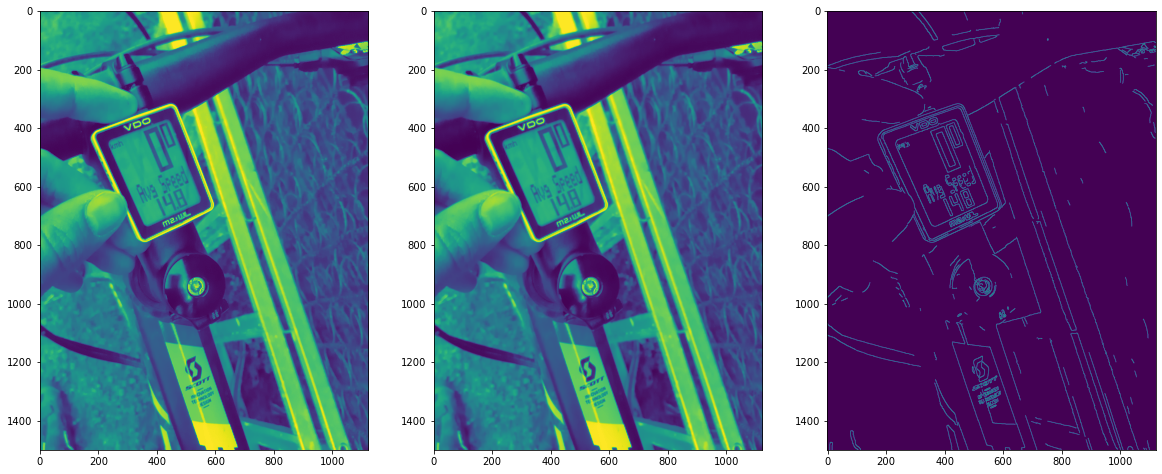

In [22]:

path = '../test_images/20191026_142122.jpg'
# path = '../test_images/20190925_184008.jpg'
path = '../test_images/20200911_190211_thumb.jpg'
# path = '../test_images/20200507_191123.jpg'
# load the example image
image = cv2.imread(path)
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=1500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 100, 150, 255,)
# edged = cv2.Canny(blurred, 200, 255, 255,)

# cv2.imshow("Input", image)
# cv2.imshow("Output", output)

#Show the image with matplotlib
fig, ax = plt.subplots(1,3,figsize=(20,16))
ax[0].imshow(gray)
ax[1].imshow(blurred)
ax[2].imshow(edged)
fig.show()


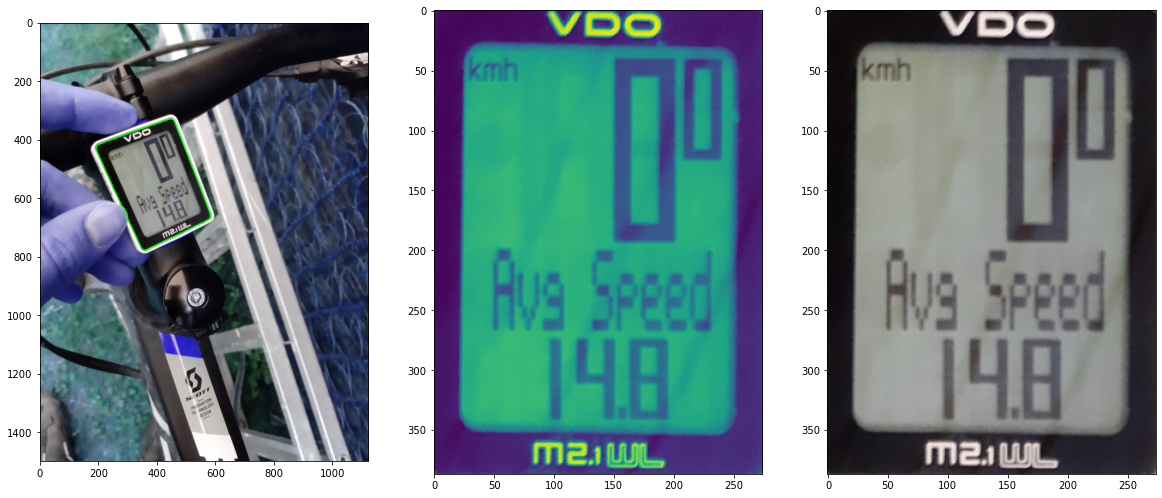

In [23]:
# find contours in the edge map, then sort them by their
# size in descending order
# contours, hierarchy  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy  = cv2.findContours(edged.copy(), mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
# contours, hierarchy  = cv2.findContours(edged.copy(), mode=cv2.RETR_TREE,method=cv2.CHAIN_APPROX_NONE)

# cnts = imutils.grab_contours(cnts)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

displayCnt = None
# loop over the contours
for i,c in enumerate(contours):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        break
detected_contour = contours[i].copy()
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

image_with_contour =image.copy()
cv2.drawContours(image_with_contour, detected_contour, -1, (0, 255, 0), 3)

fig, ax = plt.subplots(1,3,figsize=(20,16))

ax[0].imshow(image_with_contour)
ax[1].imshow(warped)
ax[2].imshow(output)

fig.show()

## reapply edging: 

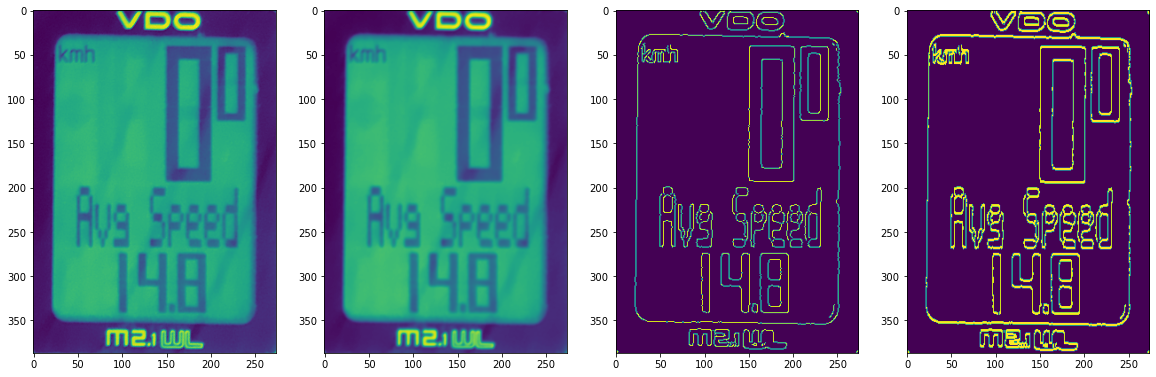

In [24]:
gray_again = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
blurred_again = cv2.GaussianBlur(gray_again, (5, 5), 0)
edged_again = cv2.Canny(blurred_again, 25, 100,255)
# edged = cv2.Canny(blurred, 200, 255, 255,)
dilation=cv2.dilate(edged_again.copy(),(9,9),iterations = 2)
# cv2.imshow("Input", image)
# cv2.imshow("Output", output)

#Show the image with matplotlib
fig, ax = plt.subplots(1,4,figsize=(20,16))
ax[0].imshow(gray_again)
ax[1].imshow(blurred_again)
ax[2].imshow(edged_again)
ax[3].imshow(dilation)
fig.show()

## reapply contours

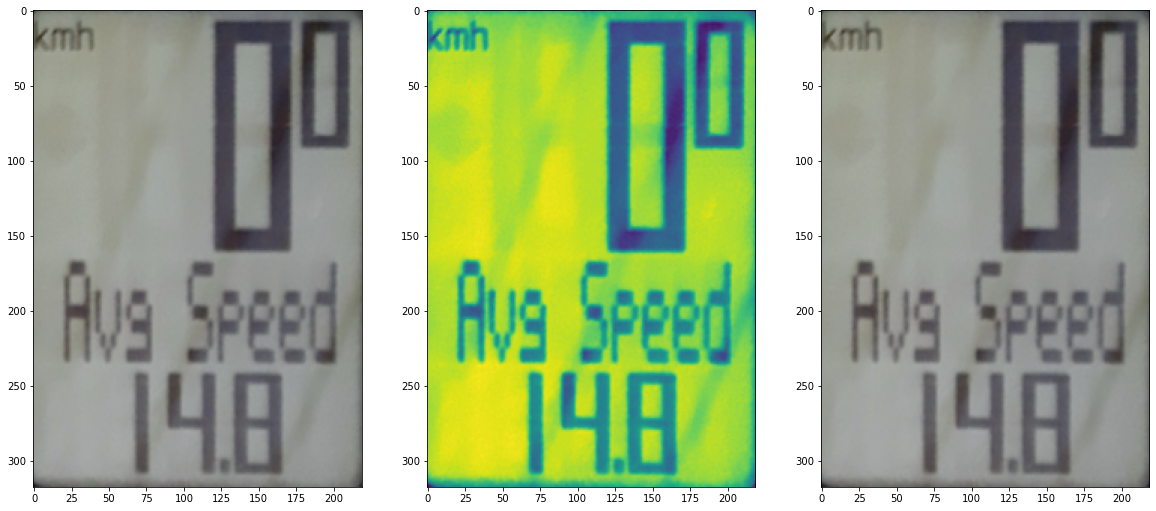

In [25]:

contours_again, hierarchy_again  = cv2.findContours(dilation, mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
# contours, hierarchy  = cv2.findContours(edged.copy(), mode=cv2.RETR_TREE,method=cv2.CHAIN_APPROX_NONE)

# cnts = imutils.grab_contours(cnts)
contours_again = sorted(contours_again, key=cv2.contourArea, reverse=True)

displayCnt = None

# loop over the contours
to_break= 0
for i,c in enumerate(contours_again):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        if to_break ==3:
            break
        else:
            to_break+=1


detected_contour = contours[2].copy()
warped_again = four_point_transform(gray_again, displayCnt.reshape(4, 2))
output_again = four_point_transform(output, displayCnt.reshape(4, 2))

image_with_contour =output_again.copy()
cv2.drawContours(image_with_contour, detected_contour, -1, (0, 255, 0), 3)

fig, ax = plt.subplots(1,3,figsize=(20,16))

ax[0].imshow(image_with_contour)
ax[1].imshow(warped_again)
ax[2].imshow(output_again)

fig.show()

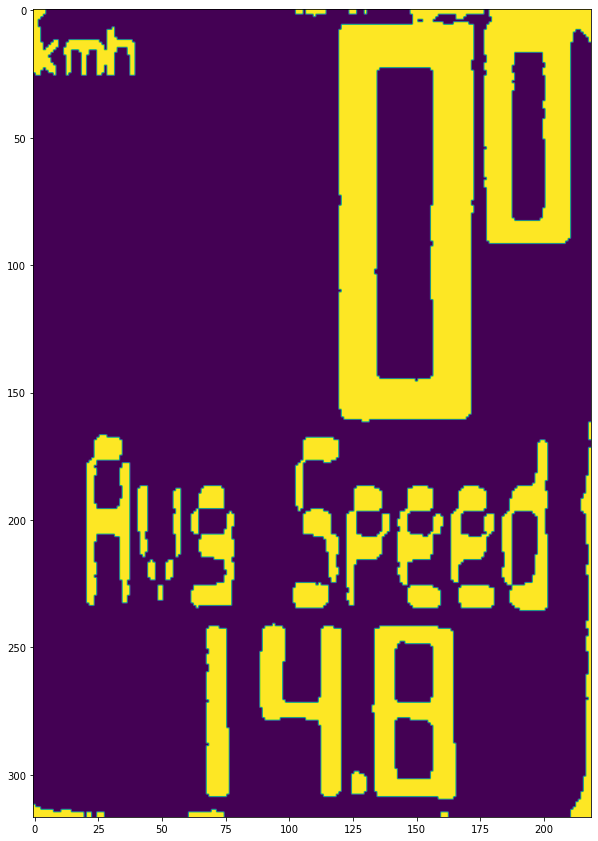

In [121]:
thresh = cv2.threshold(warped_again, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 3))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

fig, ax = plt.subplots(1,1,figsize=(10,16))

ax.imshow(thresh)

fig.show()


In [107]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # if the contour is sufficiently large, it must be a digit
#     if w >= 150 and (h >= 300 ): #and h <= 400):
#         digitCnts.append(c)
    digitCnts.append(c)


In [108]:
roi_n=[] #store each bounding box for later
for d in range(0,len(digitCnts)):    
    x=rect_d[i][0] #Find x 
    y=rect_d[i][1] #Find y 
    w=rect_d[i][2] #Find width 
    h=rect_d[i][3] #Find height 
    roi=imgFinal[y:y+h,x:x+w]
    roi_n.append(roi)

NameError: name 'rect_d' is not defined

NameError: name 'digitCnts' is not defined

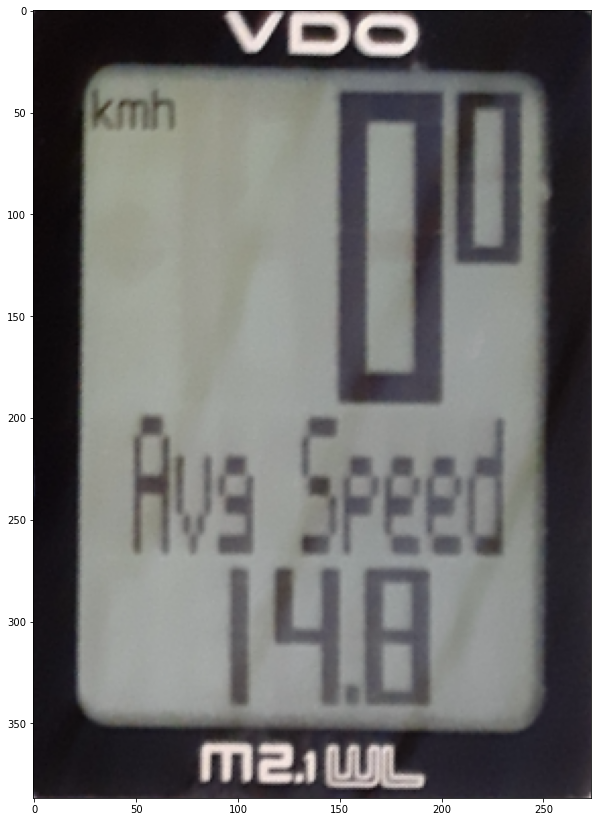

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,16))


ax.imshow(output)
for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    rect = cv2.rectangle(output, (x,y),(x+w,y+h), (0, 0, 255),1)
    ax.imshow(rect)

fig.show()

# Testing tesseract: 

In [32]:
boxes = pytesseract.image_to_data(output_again,)
boxes

'level\tpage_num\tblock_num\tpar_num\tline_num\tword_num\tleft\ttop\twidth\theight\tconf\ttext\n1\t1\t0\t0\t0\t0\t0\t0\t219\t318\t-1\t\n'

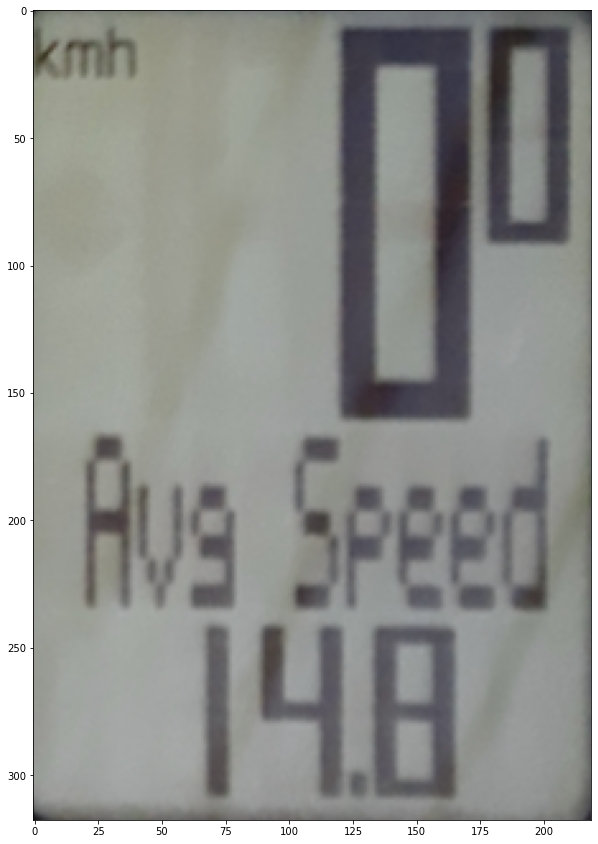

In [33]:
h, w, c = output_again.shape
boxes = pytesseract.image_to_boxes(output_again,)
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(output_again, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# cv2.imshow('img', output)

fig, ax = plt.subplots(1,1,figsize=(10,16))

ax.imshow(output_again)

fig.show()

In [34]:
d = pytesseract.image_to_data(output_again, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [18]:
d

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 0, 0, 0, 0],
 'top': [0, 0, 0, 0, 0],
 'width': [186, 186, 186, 186, 186],
 'height': [252, 252, 252, 252, 252],
 'conf': ['-1', '-1', '-1', '-1', 95],
 'text': ['', '', '', '', '']}

In [23]:
d['text']

['', '', '', '', '']

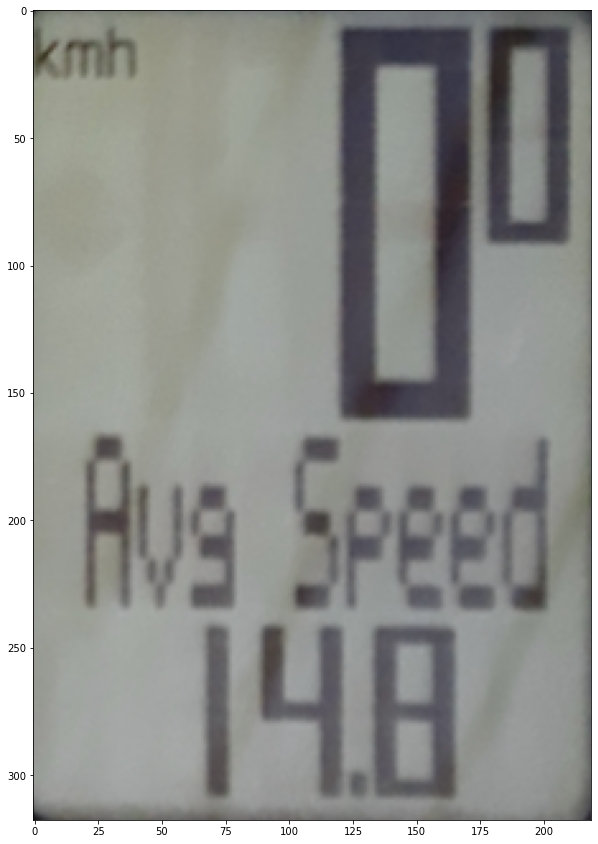

In [35]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(output_again, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
fig, ax = plt.subplots(1,1,figsize=(10,16))

ax.imshow(output_again)

fig.show()